# Подготовка среды

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/Shared drives/hse_BERT/hse_Af_Tr_BERT')

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.8MB 8.3MB/s 
     |████████████████████████████████| 3.2MB 36.3MB/s 
     |████████████████████████████████| 890kB 45.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=507d536dd818087802ad1954a5f891f3dc924ce314669fe979ce264bc1f411df
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
!pip install razdel

In [ ]:
import torch
import nltk
import re
import json
import time
import numpy as np
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
% matplotlib inline

from scipy.spatial.distance import cosine

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

In [ ]:
model = BertModel.from_pretrained('DeepPavlov/rubert-base-cased-sentence',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )
model.eval()

In [ ]:
import pickle as pc

def my_dump(file, name):
    with open("./bin/" + name + ".pic", 'wb') as f:
        pc.dump(file, f)

def my_load(name):
    with open("./bin/" + name + ".pic", 'rb') as f:
        return pc.load(f)

In [ ]:
from razdel import sentenize

# short 

## generate (split) sentences

In [ ]:
with open("./texts/all_cyberleninka_polit2/all_cyberleninka_polit2.txt", 'r') as f:
    data = f.read()

In [ ]:
%%time
sent2 = list(sentenize(data))

CPU times: user 1min 55s, sys: 911 ms, total: 1min 56s
Wall time: 1min 56s


In [ ]:
%%time
my_dump(sent2, "sent2")
# my_dump(sent2, "sent2")

CPU times: user 7.96 s, sys: 2.43 s, total: 10.4 s
Wall time: 14.3 s


## read sentences

In [ ]:
%%time
sent1 = my_load("sent2")

CPU times: user 8.71 s, sys: 1.77 s, total: 10.5 s
Wall time: 13.7 s


In [ ]:
def get_text_from_ST(ss):
    return ss.text

In [ ]:
sent = list(map(get_text_from_ST, sent1))

In [ ]:
len(sent)

2348859

## work

In [ ]:
text = "Беллетристика — это старинное название всей художественной литературы, король, королева, королю, королям, королем, королями"


In [ ]:
for_embeddings = {
    "король", 
    "королева",
    "мужчина",
    "женьщина"
}

In [ ]:
def sum_tensors(token):
    return torch.sum(token[-4:], dim=0)

def get_embeddings(text):
    tokenized_text = tokenizer.tokenize("[CLS] " + text.lower() + " [SEP]")
    if len(tokenized_text) > 80:
        return [],[]
    marked_text = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(tokenized_text)

    tokens_tensor = torch.tensor([marked_text])
    segments_tensors = torch.tensor([segments_ids])

    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs[2]

    token_embeddings = torch.squeeze(torch.stack(hidden_states, dim=0),
                                    dim=1).permute(1,0,2)
    
    token_vecs_sum = list(map(sum_tensors, token_embeddings))
    return tokenized_text, token_vecs_sum

# token_vecs = hidden_states[-2][0]
# sentence_embedding = torch.mean(token_vecs, dim=0)

In [ ]:
pr_tr = dict.fromkeys(for_embeddings)
for i in pr_tr:
    pr_tr[i] = []

pr_tr

{'женьщина': [], 'королева': [], 'король': [], 'мужчина': []}

In [ ]:
# words = re.compile('\w+')
# words.fullmatch("khbkjhk")
# re.fullmatch(r'\w+', "12kb12lkjnl")

In [ ]:
# %%time
# for j in range(1):
#     for i in range(j * 100, (j + 1) * 100):
#         tt, tvs = get_embeddings(sent[i])
#         for i in range(len(tt)):
#             if tt[i].isalpha():
#                 if tt[i] in pr_tr:
#                     pr_tr[tt[i]].append(tvs[i])
#                 else:
#                     pr_tr[tt[i]] = [tvs[i]]

# for i in pr_tr:
#     print(i, len(pr_tr[i]))

In [ ]:
%%time
batch = 1000
start_time = time.time()
for j in range(50):
    pr_tr = {}
    temp_time = time.time()
    for i in range(j * batch, (j + 1) * batch):
        tt, tvs = get_embeddings(sent[i])
        for i in range(len(tt)):
            if tt[i].isalpha() and len(tt[i]) > 2 :
                if tt[i] in pr_tr:
                    pr_tr[tt[i]].append(tvs[i])
                else:
                    pr_tr[tt[i]] = [tvs[i]]

    with open("./embeddings/sent2/bin/{}_{:05d}.pic".format(batch, j), 'wb') as f:
        pc.dump(pr_tr, f)

    # with open("./embeddings/sent1/json/{:05d}.pic".format(i), 'w') as f:
    #     json.dump(pr_tr, f)

    t = time.time()
    print("done {:05d} --- time: {}\t--- total: {}".format(j, t - temp_time, t - start_time))

# for i in pr_tr:
#     print(i, len(pr_tr[i]))

done 00000 --- time: 138.55692505836487	--- total: 138.56861352920532
done 00001 --- time: 126.4281358718872	--- total: 265.0187737941742
done 00002 --- time: 134.3370807170868	--- total: 399.3687114715576
done 00003 --- time: 138.26550722122192	--- total: 537.6553409099579
done 00004 --- time: 144.21988725662231	--- total: 681.8997201919556
done 00005 --- time: 135.67495274543762	--- total: 817.595596075058
done 00006 --- time: 132.86657118797302	--- total: 950.4830794334412
done 00007 --- time: 134.00604271888733	--- total: 1084.5090637207031
done 00008 --- time: 136.71471071243286	--- total: 1221.2424449920654
done 00009 --- time: 131.8957953453064	--- total: 1353.1561915874481
done 00010 --- time: 137.9220016002655	--- total: 1491.0963106155396
done 00011 --- time: 135.7893271446228	--- total: 1626.9053962230682
done 00012 --- time: 133.90121412277222	--- total: 1760.8267829418182
done 00013 --- time: 142.40506744384766	--- total: 1903.2497158050537
done 00014 --- time: 136.2299354

In [ ]:
%%time
batch = 1000
start_time = time.time()
for j in range(800, 900):
    pr_tr = {}
    temp_time = time.time()
    for i in range(j * batch, (j + 1) * batch):
        tt, tvs = get_embeddings(sent[i])
        for i in range(len(tt)):
            if tt[i].isalpha() and len(tt[i]) > 2 :
                if tt[i] in pr_tr:
                    pr_tr[tt[i]].append(tvs[i])
                else:
                    pr_tr[tt[i]] = [tvs[i]]

    with open("./embeddings/sent2/bin/{}_{:05d}.pic".format(batch, j), 'wb') as f:
        pc.dump(pr_tr, f)

    # with open("./embeddings/sent1/json/{:05d}.pic".format(i), 'w') as f:
    #     json.dump(pr_tr, f)

    t = time.time()
    print("done {:05d} --- time: {}\t--- total: {}".format(j, t - temp_time, t - start_time))

# for i in pr_tr:
#     print(i, len(pr_tr[i]))

done 00800 --- time: 144.100839138031	--- total: 144.12456107139587
done 00801 --- time: 155.34966468811035	--- total: 299.4998002052307
done 00802 --- time: 140.92714142799377	--- total: 440.44868659973145
done 00803 --- time: 130.68446588516235	--- total: 571.1552886962891
done 00804 --- time: 138.5334930419922	--- total: 709.7078716754913
done 00805 --- time: 144.62314796447754	--- total: 854.351722240448
done 00806 --- time: 141.297217130661	--- total: 995.6758522987366
done 00807 --- time: 133.29343962669373	--- total: 1128.992061138153
done 00808 --- time: 136.55790948867798	--- total: 1265.569312095642
done 00809 --- time: 143.41161632537842	--- total: 1409.0047161579132
done 00810 --- time: 133.251282453537	--- total: 1542.2781929969788
done 00811 --- time: 138.42495036125183	--- total: 1680.7282454967499
done 00812 --- time: 139.09763836860657	--- total: 1819.853816986084
done 00813 --- time: 147.2785313129425	--- total: 1967.1554164886475
done 00814 --- time: 135.734702587127

In [ ]:
%%time
batch = 1000
start_time = time.time()
for j in range(419, 500):
    pr_tr = {}
    temp_time = time.time()
    for i in range(j * batch, (j + 1) * batch):
        tt, tvs = get_embeddings(sent[i])
        for i in range(len(tt)):
            if tt[i].isalpha() and len(tt[i]) > 2 :
                if tt[i] in pr_tr:
                    pr_tr[tt[i]].append(tvs[i])
                else:
                    pr_tr[tt[i]] = [tvs[i]]

    with open("./embeddings/sent2/bin/{}_{:05d}.pic".format(batch, j), 'wb') as f:
        pc.dump(pr_tr, f)

    # with open("./embeddings/sent1/json/{:05d}.pic".format(i), 'w') as f:
    #     json.dump(pr_tr, f)

    t = time.time()
    print("done {:05d} --- time: {}\t--- total: {}".format(j, t - temp_time, t - start_time))

# for i in pr_tr:
#     print(i, len(pr_tr[i]))

done 00419 --- time: 148.32061409950256	--- total: 148.32061624526978
done 00420 --- time: 146.7000207901001	--- total: 295.0449619293213
done 00421 --- time: 154.04912066459656	--- total: 449.11687183380127
done 00422 --- time: 150.9402310848236	--- total: 600.085355758667
done 00423 --- time: 156.09497380256653	--- total: 756.2035384178162
done 00424 --- time: 151.76136875152588	--- total: 907.9881989955902
done 00425 --- time: 139.8435022830963	--- total: 1047.8554179668427
done 00426 --- time: 147.5427429676056	--- total: 1195.4172382354736
done 00427 --- time: 150.37908959388733	--- total: 1345.820737361908
done 00428 --- time: 153.50757813453674	--- total: 1499.356665611267
done 00429 --- time: 152.30788731575012	--- total: 1651.6945078372955
done 00430 --- time: 149.00155305862427	--- total: 1800.7246973514557
done 00431 --- time: 137.72184920310974	--- total: 1938.4748249053955
done 00432 --- time: 149.4128406047821	--- total: 2087.913028717041
done 00433 --- time: 144.80216050

In [ ]:
out = list(zip(pr_tr.keys(), list(map(len, pr_tr.values()))))
out.sort(key = lambda i: i[1], reverse=True)
out

NameError: ignored

In [ ]:
np.array(pr_tr)

In [ ]:
marked_text = "[CLS] " + text.lower() + " [SEP]"
tokenized_text = tokenizer.tokenize(marked_text)
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
segments_ids = [1] * len(tokenized_text)

# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

with torch.no_grad():
    outputs = model(tokens_tensor, segments_tensors)
    hidden_states = outputs[2]

# Remove dimension 1, the "batches".
token_embeddings = torch.stack(hidden_states, dim=0)
token_embeddings = torch.squeeze(token_embeddings, dim=1).permute(1,0,2)

token_vecs_sum = []
for token in token_embeddings:
    sum_vec = torch.sum(token[-4:], dim=0)
    token_vecs_sum.append(sum_vec)

for i, token_str in enumerate(tokenized_text):
    print (i, token_str)

token_vecs = hidden_states[-2][0]
sentence_embedding = torch.mean(token_vecs, dim=0)


In [ ]:

diff_bank = 1 - cosine(token_vecs_sum[11], token_vecs_sum[12])
print('Vector similarity for  *similar*  meanings:  %.2f' % diff_bank)

Vector similarity for  *similar*  meanings:  0.74


In [ ]:
?sent1[0]

## old work

In [ ]:
text = 'Чтобы не грусть, что вместо сети определили на пары.'
text2 = "At eight o'clock on Thursday morning. Arthur didn't feel very good."

In [ ]:
marked_text = "[CLS] " + text.lower() + " [SEP]"
tokenized_text = tokenizer.tokenize(marked_text)
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
segments_ids = [1] * len(tokenized_text)

In [ ]:
tokenized_text

['[CLS]',
 'чтобы',
 'не',
 'груст',
 '##ь',
 ',',
 'что',
 'вместо',
 'сети',
 'определили',
 'на',
 'пары',
 '.',
 '[SEP]']

In [ ]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [ ]:
with torch.no_grad():
    outputs = model(tokens_tensor, segments_tensors)
    hidden_states = outputs[2]

In [ ]:
# token_i = 5
# layer_i = 5
# vec = hidden_states[layer_i][batch_i][token_i]

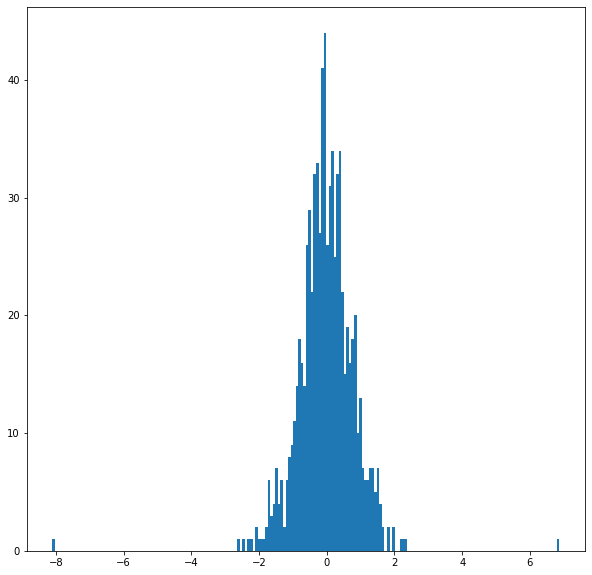

In [ ]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = hidden_states[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

In [ ]:
# Remove dimension 1, the "batches".
token_embeddings = torch.stack(hidden_states, dim=0)
token_embeddings = torch.squeeze(token_embeddings, dim=1).permute(1,0,2)

In [ ]:
token_vecs_sum = []
for token in token_embeddings:
    sum_vec = torch.sum(token[-4:], dim=0)
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 17 x 768


In [ ]:
len(token_vecs_sum)

17

In [ ]:
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)

0 [CLS]
1 замок
2 сто
3 ##ял
4 не
5 ##пр
6 ##ист
7 ##уп
8 ##ныи
9 .
10 замок
11 легко
12 от
13 ##крыл
14 ##ся
15 .
16 [SEP]


In [ ]:
token_vecs = hidden_states[-2][0]
sentence_embedding = torch.mean(token_vecs, dim=0)

In [ ]:
token_vecs.size()

torch.Size([17, 768])

In [ ]:
diff_bank = 1 - cosine(token_vecs_sum[1], token_vecs_sum[10])
diff_bank1 = 1 - cosine(token_vecs[1], token_vecs[10])
# same_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[6])

print('Vector similarity for  *similar*  meanings:  %.2f' % diff_bank)
# print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

Vector similarity for  *similar*  meanings:  0.92
